In [32]:
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv3D, Conv2D, AveragePooling2D, AveragePooling3D
from keras.layers.pooling import MaxPooling3D,MaxPooling2D
from keras.layers import Dense, GlobalAveragePooling3D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.utils import np_utils, generic_utils
from keras.layers.convolutional_recurrent import ConvLSTM2D
from resnet3d import Resnet3DBuilder

import theano
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import csv
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
import sklearn

In [33]:
img_rows = 96
img_cols = 64
batch_size = 32
DATA = "./jesture/20bn-jester-v1"
LABEL = "./jesture/jester-v1-all.xlsx"
LABELLIST = "./jesture/jester-v1-labels.xlsx"

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def oneHot(values):
    lf = LabelEncoder().fit(values)
    data_label = lf.transform(values)
    
    of = OneHotEncoder(sparse = False).fit(data_label.reshape(-1,1))  
    data_ohe = of.transform(data_label.reshape(-1,1))
    return data_ohe

In [35]:
import xlrd
from keras.utils import np_utils

ListOfLabel = xlrd.open_workbook(LABEL)
names = ListOfLabel.sheet_names()
print(names)

labels = ListOfLabel.sheet_by_index(0)
nrows = labels.nrows
print(nrows)

tserial_num = labels.col_values(0)
tlabels = labels.col_values(1)

serial_num = []
labels = []

i = 0
for i in range(0, len(tlabels)):
    if tlabels[i] == "Swiping Left":
        serial_num.append(tserial_num[i])
        labels.append(tlabels[i])
    if tlabels[i] == "Swiping Right":
        serial_num.append(tserial_num[i])
        labels.append(tlabels[i])
    if tlabels[i] == "Pulling Hand In":
        serial_num.append(tserial_num[i])
        labels.append(tlabels[i])
#     if tlabels[i] == "Swiping Up":
#         serial_num.append(tserial_num[i])
#         labels.append(tlabels[i])
#     if tlabels[i] == "Swiping Down":
#         serial_num.append(tserial_num[i])
#         labels.append(tlabels[i])
#     if tlabels[i] == "Sliding Two Fingers Right":
#         serial_num.append(tserial_num[i])
#         labels.append(tlabels[i])
#     if tlabels[i] == "Thumb Down":
#         serial_num.append(tserial_num[i])
#         labels.append(tlabels[i])
    if tlabels[i] == "Thumb Up":
        serial_num.append(tserial_num[i])
        labels.append(tlabels[i])
    if tlabels[i] == "Shaking Hand":
        serial_num.append(tserial_num[i])
        labels.append(tlabels[i])
#     if tlabels[i] == "Stop Sign":
#         serial_num.append(tserial_num[i])
#         labels.append(tlabels[i])
    i = i + 1
    if len(labels) == 2500:
        break

# y_train = labels[0:2000]
# y_train = np.array(y_train)
# y_val = labels[2000:2500]
# y_val = np.array(y_val) 

# y_train = oneHot(y_train)
# y_val = oneHot(y_val)
# print(y_train.shape)
# print(y_val.shape)
# print(len(serial_num))


def toInt(x):
    return str(int(x))
serial_num = list(map(toInt, serial_num))
print(serial_num)

['Sheet4']
23350
['4', '47', '166', '185', '214', '235', '287', '343', '369', '381', '477', '530', '552', '566', '605', '607', '609', '658', '689', '694', '715', '758', '759', '761', '843', '877', '887', '890', '943', '966', '1022', '1024', '1089', '1112', '1157', '1191', '1322', '1435', '1458', '1476', '1497', '1542', '1568', '1598', '1660', '1722', '1736', '1769', '1816', '1828', '1835', '1875', '1896', '1901', '1903', '1930', '1939', '1945', '1984', '2109', '2119', '2163', '2328', '2334', '2427', '2428', '2454', '2485', '2494', '2507', '2545', '2671', '2682', '2726', '2860', '2871', '2875', '2885', '2891', '2915', '2939', '2991', '3018', '3020', '3113', '3154', '3179', '3218', '3249', '3271', '3347', '3370', '3393', '3403', '3406', '3429', '3446', '3506', '3515', '3518', '3537', '3557', '3626', '3630', '3642', '3715', '3738', '3831', '3841', '3854', '3919', '3924', '3934', '3961', '4007', '4017', '4018', '4024', '4136', '4173', '4233', '4350', '4376', '4426', '4439', '4452', '4495',

In [36]:
img_nums = 16

def applyPCA(X):
    newX = np.reshape(X, (X.shape[0], -1))
    newX = np.rollaxis(newX, 1, 0)
#     print('beforePCA')
#     print(newX.shape)
    pca = PCA(n_components=img_nums)
#     pca = PCA(n_components=0.98)
    newX = pca.fit_transform(newX)
#     print('afterPCA')
#     print(newX.shape)
    newX = np.rollaxis(newX, 1, 0)
    newX = np.reshape(newX, (newX.shape[0], X.shape[1], X.shape[2], X.shape[3]))
#     print(newX.shape)
    return newX

In [37]:
from tqdm import tqdm
import sklearn

dataPath = os.path.join(DATA)
#数据集路径
listOfData = os.listdir(dataPath)
listOfData.sort(key=lambda x: int(x.split('.')[0]))

with open("./frame.csv","w",newline="") as f:
    column_name = ["frame"]
    writer = csv.writer(f)
    writer.writerow(column_name)

    data = []
    numOfData = 0
    i = 0
    for ls in tqdm(listOfData):
        if not ls == serial_num[i]:
            continue
        i = i + 1
        
        listOfImgs = sorted(os.listdir(os.path.join(dataPath,ls)))
        frames = []
        #文件夹中图片数量
        imgn = 0
        writer.writerow(ls)
    #     print(ls)
        for imgs in listOfImgs:
            #图片路径
            imgPath = os.path.join(os.path.join(dataPath, ls), imgs)
            #读图片
            frame = cv2.imread(imgPath)
#             print(imgs)
            
#             frame = cv2.resize(frame, (img_rows, img_cols), interpolation = cv2.INTER_AREA)
#             print(frame.shape)
#             gray = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#             print(gray.shape)
            frame = cv2.resize(frame, (img_rows, img_cols), interpolation = cv2.INTER_AREA)
#             print(frame)
#             cv2.normalize(frame, frame)
#             print(frame)
#             print(frame.shape)
            img_gray = cv2.cvtColor(frame,cv2.COLOR_RGB2GRAY)
#             print(frame.shape)
            
#             frame = Image.open(imgPath).convert('L')
#             frame = frame.resize((img_rows,img_cols),Image.ANTIALIAS)
#             frame = np.array(frame)
#             print(frame.shape)
#             print(img_gray)
            img_gray = img_gray - 127.5
            img_gray = img_gray/255
#             cv2.normalize(img_gray,None,0,255,cv2.NORM_MINMAX)
#             img_gray = sklearn.preprocessing.normalize(img_gray, norm='l1')
#             print(img_gray)
            
            frame = np.reshape(img_gray, (img_gray.shape[0], img_gray.shape[1], 1))
            frames.append(frame)
            imgn = imgn + 1
            
            
            
            

        if imgn < 16:
            while(imgn < 16):
                frames.append(frame)
                imgn = imgn + 1

        input_img = np.array(frames)
#         print(input_img.shape)
        
        
#         input_img = input_img[3:13]
        input_img = applyPCA(input_img)
    
#         j = 0
#         for timg in input_img:
#             print(len(ipt))
#             name = str(j) + '.png'
#             cv2.imwrite(name, timg)
#             break
#         print(input_img.shape)

        #更换轴的顺序
#         ipt = np.rollaxis(np.rollaxis(input_img, 2, 0), 2, 0)
    #     print(ipt.shape)
        
        data.append(input_img)
        numOfData = numOfData + 1

        if(numOfData == 2500):
            break
    
print(len(data))


# x_train = data[0:2000]
# print(len(x_train))
# x_val = data[2000:2500]
# print(len(x_val))

# ndata = np.array(data)
# x_train = np.array(x_train)
# # print(x_train.shape)
# x_val = np.array(x_val)



  0%|          | 0/23350 [00:00<?, ?it/s]

  0%|          | 1/23350 [00:00<39:58,  9.73it/s]

  0%|          | 11/23350 [00:00<29:20, 13.26it/s]

  0%|          | 25/23350 [00:00<22:26, 17.32it/s]

  0%|          | 29/23350 [00:00<18:57, 20.50it/s]

  0%|          | 33/23350 [00:00<19:50, 19.59it/s]

  0%|          | 40/23350 [00:00<16:09, 24.03it/s]

  0%|          | 63/23350 [00:01<12:20, 31.44it/s]

  0%|          | 69/23350 [00:01<14:06, 27.50it/s]

  0%|          | 81/23350 [00:01<11:36, 33.42it/s]

  0%|          | 87/23350 [00:01<10:23, 37.31it/s]

  0%|          | 93/23350 [00:01<09:33, 40.58it/s]

  0%|          | 101/23350 [00:01<08:41, 44.60it/s]

  0%|          | 113/23350 [00:02<07:18, 53.00it/s]

  1%|          | 120/23350 [00:02<08:38, 44.80it/s]

  1%|          | 126/23350 [00:02<12:02, 32.16it/s]

  1%|          | 145/23350 [00:02<09:11, 42.04it/s]

  1%|          | 160/23350 [00:03<08:37, 44.82it/s]

  1%|          | 167/23350 [00:03<10:44, 35.97it/s]

  1%|        

  6%|▌         | 1444/23350 [00:24<10:07, 36.03it/s]

  6%|▋         | 1479/23350 [00:25<07:35, 48.03it/s]

  6%|▋         | 1491/23350 [00:25<06:20, 57.43it/s]

  6%|▋         | 1501/23350 [00:25<05:55, 61.51it/s]

  6%|▋         | 1517/23350 [00:25<05:09, 70.56it/s]

  7%|▋         | 1528/23350 [00:25<05:14, 69.35it/s]

  7%|▋         | 1537/23350 [00:25<06:28, 56.11it/s]

  7%|▋         | 1549/23350 [00:26<05:40, 64.10it/s]

  7%|▋         | 1558/23350 [00:26<07:23, 49.09it/s]

  7%|▋         | 1570/23350 [00:26<06:26, 56.38it/s]

  7%|▋         | 1581/23350 [00:26<05:59, 60.57it/s]

  7%|▋         | 1595/23350 [00:26<05:21, 67.67it/s]

  7%|▋         | 1603/23350 [00:27<08:29, 42.67it/s]

  7%|▋         | 1612/23350 [00:27<08:41, 41.71it/s]

  7%|▋         | 1618/23350 [00:27<10:19, 35.07it/s]

  7%|▋         | 1629/23350 [00:27<09:31, 37.98it/s]

  7%|▋         | 1634/23350 [00:27<10:26, 34.66it/s]

  7%|▋         | 1640/23350 [00:28<10:20, 34.98it/s]

  7%|▋         | 1649/23350 

 13%|█▎        | 3075/23350 [00:53<05:39, 59.69it/s]

 13%|█▎        | 3091/23350 [00:53<04:51, 69.48it/s]

 13%|█▎        | 3100/23350 [00:53<05:58, 56.47it/s]

 13%|█▎        | 3115/23350 [00:53<05:17, 63.76it/s]

 13%|█▎        | 3140/23350 [00:53<04:21, 77.29it/s]

 13%|█▎        | 3151/23350 [00:54<05:51, 57.43it/s]

 14%|█▎        | 3160/23350 [00:54<05:54, 56.97it/s]

 14%|█▎        | 3172/23350 [00:54<05:31, 60.93it/s]

 14%|█▎        | 3180/23350 [00:54<07:17, 46.15it/s]

 14%|█▎        | 3197/23350 [00:55<06:10, 54.41it/s]

 14%|█▎        | 3205/23350 [00:55<08:12, 40.92it/s]

 14%|█▍        | 3212/23350 [00:55<07:23, 45.45it/s]

 14%|█▍        | 3218/23350 [00:55<11:16, 29.76it/s]

 14%|█▍        | 3234/23350 [00:56<09:12, 36.39it/s]

 14%|█▍        | 3240/23350 [00:56<10:18, 32.54it/s]

 14%|█▍        | 3248/23350 [00:56<08:42, 38.46it/s]

 14%|█▍        | 3254/23350 [00:56<10:53, 30.74it/s]

 14%|█▍        | 3278/23350 [00:56<08:19, 40.17it/s]

 14%|█▍        | 3286/23350 

 21%|██        | 4807/23350 [01:17<05:31, 55.86it/s]

 21%|██        | 4814/23350 [01:17<07:16, 42.47it/s]

 21%|██        | 4820/23350 [01:17<06:44, 45.85it/s]

 21%|██        | 4851/23350 [01:17<05:07, 60.10it/s]

 21%|██        | 4862/23350 [01:18<05:08, 59.88it/s]

 21%|██        | 4886/23350 [01:18<04:16, 71.86it/s]

 21%|██        | 4897/23350 [01:18<05:00, 61.47it/s]

 21%|██        | 4906/23350 [01:19<09:31, 32.26it/s]

 21%|██        | 4923/23350 [01:19<07:44, 39.69it/s]

 21%|██        | 4931/23350 [01:19<06:41, 45.87it/s]

 21%|██        | 4939/23350 [01:19<06:22, 48.07it/s]

 21%|██        | 4946/23350 [01:20<12:10, 25.19it/s]

 21%|██        | 4957/23350 [01:20<10:11, 30.08it/s]

 21%|██▏       | 4965/23350 [01:20<09:14, 33.16it/s]

 21%|██▏       | 4972/23350 [01:20<11:08, 27.50it/s]

 21%|██▏       | 4985/23350 [01:21<08:47, 34.83it/s]

 21%|██▏       | 4991/23350 [01:21<08:38, 35.41it/s]

 21%|██▏       | 4997/23350 [01:21<08:29, 36.05it/s]

 21%|██▏       | 5005/23350 

 27%|██▋       | 6376/23350 [01:41<04:35, 61.67it/s]

 27%|██▋       | 6384/23350 [01:42<05:51, 48.25it/s]

 27%|██▋       | 6391/23350 [01:42<05:36, 50.36it/s]

 27%|██▋       | 6398/23350 [01:42<06:08, 45.98it/s]

 27%|██▋       | 6404/23350 [01:42<06:40, 42.31it/s]

 27%|██▋       | 6419/23350 [01:42<05:36, 50.32it/s]

 28%|██▊       | 6440/23350 [01:42<04:34, 61.50it/s]

 28%|██▊       | 6449/23350 [01:43<05:39, 49.79it/s]

 28%|██▊       | 6462/23350 [01:43<05:56, 47.34it/s]

 28%|██▊       | 6468/23350 [01:43<10:18, 27.29it/s]

 28%|██▊       | 6476/23350 [01:44<08:58, 31.33it/s]

 28%|██▊       | 6500/23350 [01:44<06:45, 41.58it/s]

 28%|██▊       | 6524/23350 [01:44<05:11, 53.99it/s]

 28%|██▊       | 6536/23350 [01:44<07:01, 39.93it/s]

 28%|██▊       | 6546/23350 [01:45<06:30, 43.05it/s]

 28%|██▊       | 6555/23350 [01:45<06:26, 43.47it/s]

 28%|██▊       | 6564/23350 [01:45<05:54, 47.32it/s]

 28%|██▊       | 6572/23350 [01:45<06:33, 42.65it/s]

 28%|██▊       | 6578/23350 

 33%|███▎      | 7810/23350 [02:08<06:49, 37.92it/s]

 33%|███▎      | 7815/23350 [02:08<07:27, 34.69it/s]

 33%|███▎      | 7819/23350 [02:08<07:21, 35.17it/s]

 34%|███▎      | 7827/23350 [02:08<06:52, 37.66it/s]

 34%|███▎      | 7836/23350 [02:08<06:11, 41.73it/s]

 34%|███▎      | 7844/23350 [02:08<05:55, 43.62it/s]

 34%|███▎      | 7858/23350 [02:09<05:11, 49.71it/s]

 34%|███▎      | 7864/23350 [02:09<06:19, 40.77it/s]

 34%|███▎      | 7873/23350 [02:09<05:54, 43.67it/s]

 34%|███▎      | 7878/23350 [02:09<06:39, 38.70it/s]

 34%|███▍      | 7891/23350 [02:09<05:26, 47.29it/s]

 34%|███▍      | 7927/23350 [02:09<04:07, 62.37it/s]

 34%|███▍      | 7939/23350 [02:09<03:54, 65.82it/s]

 34%|███▍      | 7951/23350 [02:10<03:49, 67.21it/s]

 34%|███▍      | 7967/23350 [02:10<03:16, 78.16it/s]

 34%|███▍      | 7990/23350 [02:10<02:43, 94.08it/s]

 34%|███▍      | 8007/23350 [02:10<02:38, 97.10it/s]

 34%|███▍      | 8019/23350 [02:10<02:59, 85.20it/s]

 34%|███▍      | 8030/23350 

 41%|████▏     | 9640/23350 [02:35<03:05, 73.80it/s]

 41%|████▏     | 9649/23350 [02:35<03:49, 59.78it/s]

 41%|████▏     | 9656/23350 [02:36<07:36, 29.97it/s]

 41%|████▏     | 9666/23350 [02:36<07:15, 31.44it/s]

 41%|████▏     | 9672/23350 [02:36<07:43, 29.48it/s]

 41%|████▏     | 9689/23350 [02:37<06:23, 35.58it/s]

 42%|████▏     | 9694/23350 [02:37<06:33, 34.69it/s]

 42%|████▏     | 9699/23350 [02:37<07:02, 32.35it/s]

 42%|████▏     | 9704/23350 [02:37<06:22, 35.66it/s]

 42%|████▏     | 9711/23350 [02:37<05:57, 38.11it/s]

 42%|████▏     | 9730/23350 [02:38<05:03, 44.93it/s]

 42%|████▏     | 9743/23350 [02:38<04:07, 54.97it/s]

 42%|████▏     | 9756/23350 [02:38<03:35, 63.05it/s]

 42%|████▏     | 9764/23350 [02:38<03:45, 60.22it/s]

 42%|████▏     | 9773/23350 [02:38<03:38, 62.23it/s]

 42%|████▏     | 9797/23350 [02:38<02:54, 77.50it/s]

 42%|████▏     | 9818/23350 [02:38<02:27, 91.79it/s]

 42%|████▏     | 9831/23350 [02:39<03:18, 67.99it/s]

 42%|████▏     | 9841/23350 

 48%|████▊     | 11102/23350 [03:02<02:53, 70.53it/s]

 48%|████▊     | 11114/23350 [03:02<02:53, 70.67it/s]

 48%|████▊     | 11125/23350 [03:02<02:42, 75.24it/s]

 48%|████▊     | 11139/23350 [03:02<02:28, 82.10it/s]

 48%|████▊     | 11152/23350 [03:02<02:23, 84.85it/s]

 48%|████▊     | 11163/23350 [03:02<02:39, 76.54it/s]

 48%|████▊     | 11172/23350 [03:02<03:01, 67.10it/s]

 48%|████▊     | 11185/23350 [03:03<02:35, 77.99it/s]

 48%|████▊     | 11201/23350 [03:03<02:37, 77.32it/s]

 48%|████▊     | 11210/23350 [03:03<03:14, 62.30it/s]

 48%|████▊     | 11231/23350 [03:03<02:41, 75.20it/s]

 48%|████▊     | 11241/23350 [03:04<04:20, 46.40it/s]

 48%|████▊     | 11249/23350 [03:04<04:13, 47.78it/s]

 48%|████▊     | 11256/23350 [03:04<05:46, 34.95it/s]

 48%|████▊     | 11268/23350 [03:04<04:52, 41.35it/s]

 48%|████▊     | 11299/23350 [03:04<03:36, 55.59it/s]

 48%|████▊     | 11312/23350 [03:05<03:34, 56.08it/s]

 49%|████▊     | 11328/23350 [03:05<03:22, 59.48it/s]

 49%|████▊

 55%|█████▍    | 12811/23350 [03:28<03:08, 55.97it/s]

 55%|█████▍    | 12818/23350 [03:28<03:25, 51.29it/s]

 55%|█████▍    | 12824/23350 [03:28<03:52, 45.28it/s]

 55%|█████▍    | 12834/23350 [03:28<03:31, 49.61it/s]

 55%|█████▌    | 12844/23350 [03:29<03:19, 52.55it/s]

 55%|█████▌    | 12853/23350 [03:29<03:18, 52.90it/s]

 55%|█████▌    | 12875/23350 [03:29<02:40, 65.28it/s]

 55%|█████▌    | 12884/23350 [03:29<03:15, 53.57it/s]

 55%|█████▌    | 12899/23350 [03:29<02:52, 60.60it/s]

 55%|█████▌    | 12907/23350 [03:29<03:03, 56.91it/s]

 55%|█████▌    | 12917/23350 [03:30<02:57, 58.82it/s]

 55%|█████▌    | 12924/23350 [03:30<04:06, 42.27it/s]

 55%|█████▌    | 12944/23350 [03:30<03:13, 53.81it/s]

 55%|█████▌    | 12958/23350 [03:30<02:47, 62.07it/s]

 56%|█████▌    | 12967/23350 [03:30<02:57, 58.62it/s]

 56%|█████▌    | 12975/23350 [03:31<03:31, 49.16it/s]

 56%|█████▌    | 12982/23350 [03:31<04:08, 41.72it/s]

 56%|█████▌    | 12988/23350 [03:31<04:19, 39.99it/s]

 56%|█████

2500


In [38]:
# print(x_train.shape)
# print(x_val.shape)

In [39]:
np.random.seed(16)
randomList = np.arange(2500)
np.random.shuffle(randomList)
data = np.array(data)[randomList]
# print(data)
labels = np.array(labels)[randomList]
# print(labels)

x_train = data[0:2000]
print(len(x_train))
x_val = data[2000:2500]
print(len(x_val))

ndata = np.array(data)
x_train = np.array(x_train)
# print(x_train.shape)
x_val = np.array(x_val)


y_train = labels[0:2000]
y_train = np.array(y_train)
y_val = labels[2000:2500]
y_val = np.array(y_val) 

y_train = oneHot(y_train)
y_val = oneHot(y_val)
print(y_train.shape)
print(y_val.shape)
print(len(serial_num))

print(x_train.shape)
print(x_val.shape)

2000
500
(2000, 5)
(500, 5)
2500
(2000, 16, 64, 96, 1)
(500, 16, 64, 96, 1)


/home/ilab/anaconda2/envs/HyperSpectral/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/ilab/anaconda2/envs/HyperSpectral/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, y

In [40]:
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [41]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, AveragePooling3D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras import backend as K

#Model inspired from https://arxiv.org/pdf/1412.0767.pdf
def CNN3D_dense(inp_shape, nb_classes, k_size=(3,3,3)):
    data = Input(shape=inp_shape)

    x = Conv3D(filters=(64), kernel_size=k_size, strides=(1,1,1), padding='same', activation='relu')(data)
    x = MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2))(x)    
    
    x = Conv3D(filters=(128), kernel_size=k_size, strides=(1,1,1), padding='same', activation='relu')(x)
    x = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2))(x)
    
    x = Conv3D(filters=(256), kernel_size=k_size, strides=(1,1,1), padding='same', activation='relu')(x)
    x = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2))(x)

    x = Conv3D(filters=(512), kernel_size=k_size, strides=(1,1,1), padding='same', activation='relu')(x)
    x = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2))(x)

    x = Flatten()(x)
    
    x = Dense(512, activation="relu")(x)
    x = Dense(512, activation="relu")(x)

    output = Dense(nb_classes, activation="softmax")(x)
    
    model = Model(data, output)


def CNN3D(inp_shape, nb_classes, k_size=(3,3,3), drop_rate=0):
    NB_AXIS = 1
    ROW_AXIS = 2
    COL_AXIS = 3
    data = Input(shape=inp_shape)

    x = Conv3D(filters=(64), kernel_size=k_size, strides=(1,1,1), padding='same', activation='relu')(data)
    x = MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2))(x)    
    x = Dropout(drop_rate)(x)    
    
    x = Conv3D(filters=(128), kernel_size=k_size, strides=(1,1,1), padding='same', activation='relu')(x)
    x = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2))(x)
    x = Dropout(drop_rate)(x)    
    
    x = Conv3D(filters=(256), kernel_size=k_size, strides=(1,1,1), padding='same', activation='relu')(x)
    x = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2))(x)
    x = Dropout(drop_rate)(x)    

    x = Conv3D(filters=(512), kernel_size=k_size, strides=(1,1,1), padding='same', activation='relu')(x)
    x = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2))(x)
    x = Dropout(drop_rate)(x)    

    block_shape = K.int_shape(x)
    x = AveragePooling3D(pool_size=(block_shape[NB_AXIS], block_shape[ROW_AXIS], block_shape[COL_AXIS]),strides=(1, 1, 1))(x)
    x = Flatten()(x)

    output = Dense(nb_classes, activation="softmax")(x)
    
    model = Model(data, output)

    return model
"""
class ModelLoader():
    def __init__(self, nb_classes, filters=[64, 128, 256, 512], k_size=(3,3,3))
"""

'\nclass ModelLoader():\n    def __init__(self, nb_classes, filters=[64, 128, 256, 512], k_size=(3,3,3))\n'

In [42]:
"""A vanilla 3D resnet implementation implemented by JihongJu
(See: https://github.com/JihongJu/keras-resnet3d/)

Based on Raghavendra Kotikalapudi's 2D implementation
keras-resnet (See https://github.com/raghakot/keras-resnet.)
"""
from __future__ import (
    absolute_import,
    division,
    print_function,
    unicode_literals
)
import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    Dropout
)
from keras.layers.convolutional import (
    Conv3D,
    AveragePooling3D,
    MaxPooling3D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block (by @raghakot)."""
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu3D(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault(
        "kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer",
                                                l2(1e-4))

    def f(input):
        conv = Conv3D(filters=filters, kernel_size=kernel_size,
                      strides=strides, kernel_initializer=kernel_initializer,
                      padding=padding,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv3d(**conv_params):
    """Helper to build a  BN -> relu -> conv3d block."""
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer",
                                                "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer",
                                                l2(1e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv3D(filters=filters, kernel_size=kernel_size,
                      strides=strides, kernel_initializer=kernel_initializer,
                      padding=padding,
                      kernel_regularizer=kernel_regularizer)(activation)
    return f


def _shortcut3d(input, residual):
    """3D shortcut to match input and residual and merges them with "sum"."""
    stride_dim1 = input._keras_shape[DIM1_AXIS] \
        // residual._keras_shape[DIM1_AXIS]
    stride_dim2 = input._keras_shape[DIM2_AXIS] \
        // residual._keras_shape[DIM2_AXIS]
    stride_dim3 = input._keras_shape[DIM3_AXIS] \
        // residual._keras_shape[DIM3_AXIS]
    equal_channels = residual._keras_shape[CHANNEL_AXIS] \
        == input._keras_shape[CHANNEL_AXIS]

    shortcut = input
    if stride_dim1 > 1 or stride_dim2 > 1 or stride_dim3 > 1 \
            or not equal_channels:
        shortcut = Conv3D(
            filters=residual._keras_shape[CHANNEL_AXIS],
            kernel_size=(1, 1, 1),
            strides=(stride_dim1, stride_dim2, stride_dim3),
            kernel_initializer="he_normal", padding="valid",
            kernel_regularizer=l2(1e-4)
            )(input)
    return add([shortcut, residual])


def _residual_block3d(block_function, filters, kernel_regularizer, repetitions,
                      is_first_layer=False):
    def f(input):
        for i in range(repetitions):
            strides = (1, 1, 1)
            if i == 0 and not is_first_layer:
                strides = (2, 2, 2)
            input = block_function(filters=filters, strides=strides,
                                   kernel_regularizer=kernel_regularizer,
                                   is_first_block_of_first_layer=(
                                       is_first_layer and i == 0)
                                   )(input)
        return input

    return f


def basic_block(filters, strides=(1, 1, 1), kernel_regularizer=l2(1e-4),
                is_first_block_of_first_layer=False):
    """Basic 3 X 3 X 3 convolution blocks. Extended from raghakot's 2D impl."""
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv3D(filters=filters, kernel_size=(3, 3, 3),
                           strides=strides, padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=kernel_regularizer
                           )(input)
        else:
            conv1 = _bn_relu_conv3d(filters=filters,
                                    kernel_size=(3, 3, 3),
                                    strides=strides,
                                    kernel_regularizer=kernel_regularizer
                                    )(input)

        residual = _bn_relu_conv3d(filters=filters, kernel_size=(3, 3, 3),
                                   kernel_regularizer=kernel_regularizer
                                   )(conv1)
        return _shortcut3d(input, residual)

    return f


def bottleneck(filters, strides=(1, 1, 1), kernel_regularizer=l2(1e-4),
               is_first_block_of_first_layer=False):
    """Basic 3 X 3 X 3 convolution blocks. Extended from raghakot's 2D impl."""
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv3D(filters=filters, kernel_size=(1, 1, 1),
                              strides=strides, padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=kernel_regularizer
                              )(input)
        else:
            conv_1_1 = _bn_relu_conv3d(filters=filters, kernel_size=(1, 1, 1),
                                       strides=strides,
                                       kernel_regularizer=kernel_regularizer
                                       )(input)

        conv_3_3 = _bn_relu_conv3d(filters=filters, kernel_size=(3, 3, 3),
                                   kernel_regularizer=kernel_regularizer
                                   )(conv_1_1)
        residual = _bn_relu_conv3d(filters=filters * 4, kernel_size=(1, 1, 1),
                                   kernel_regularizer=kernel_regularizer
                                   )(conv_3_3)

        return _shortcut3d(input, residual)

    return f


def _handle_data_format():
    global DIM1_AXIS
    global DIM2_AXIS
    global DIM3_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        DIM1_AXIS = 1
        DIM2_AXIS = 2
        DIM3_AXIS = 3
        CHANNEL_AXIS = 4
    else:
        CHANNEL_AXIS = 1
        DIM1_AXIS = 2
        DIM2_AXIS = 3
        DIM3_AXIS = 4


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class Resnet3DBuilder(object):
    """ResNet3D."""

    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions, reg_factor, drop_rate=0):
        """Instantiate a vanilla ResNet3D keras model.

        # Arguments
            input_shape: Tuple of input shape in the format
            (conv_dim1, conv_dim2, conv_dim3, channels) if dim_ordering='tf'
            (filter, conv_dim1, conv_dim2, conv_dim3) if dim_ordering='th'
            num_outputs: The number of outputs at the final softmax layer
            block_fn: Unit block to use {'basic_block', 'bottlenack_block'}
            repetitions: Repetitions of unit blocks
            drop_rate: rate of the dropout
        # Returns
            model: a 3D ResNet model that takes a 5D tensor (volumetric images
            in batch) as input and returns a 1D vector (prediction) as output.
        """
        _handle_data_format()
        if len(input_shape) != 4:
            raise ValueError("Input shape should be a tuple "
                             "(conv_dim1, conv_dim2, conv_dim3, channels) "
                             "for tensorflow as backend or "
                             "(channels, conv_dim1, conv_dim2, conv_dim3) "
                             "for theano as backend")

        block_fn = _get_block(block_fn)
        input = Input(shape=input_shape)
        # first conv
        conv1 = _conv_bn_relu3D(filters=64, kernel_size=(7, 7, 7),
                                strides=(2, 2, 2),
                                kernel_regularizer=l2(reg_factor)
                                )(input)
        pool1 = MaxPooling3D(pool_size=(3, 3, 3), strides=(2, 2, 2),
                             padding="same")(conv1)

        # repeat blocks
        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block3d(block_fn, filters=filters,
                                      kernel_regularizer=l2(reg_factor),
                                      repetitions=r, is_first_layer=(i == 0)
                                      )(block)
            filters *= 2
            block = Dropout(drop_rate)(block)

        # last activation
        block_output = _bn_relu(block)

        # average poll and classification
        pool2 = AveragePooling3D(pool_size=(block._keras_shape[DIM1_AXIS],
                                            block._keras_shape[DIM2_AXIS],
                                            block._keras_shape[DIM3_AXIS]),
                                 strides=(1, 1, 1))(block_output)
        flatten1 = Flatten()(pool2)
        if num_outputs > 1:
            dense = Dense(units=num_outputs,
                          kernel_initializer="he_normal",
                          activation="softmax",
                          kernel_regularizer=l2(reg_factor))(flatten1)
        else:
            dense = Dense(units=num_outputs,
                          kernel_initializer="he_normal",
                          activation="sigmoid",
                          kernel_regularizer=l2(reg_factor))(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs, reg_factor=1e-4, drop_rate=0):
        """Build resnet 18."""
        return Resnet3DBuilder.build(input_shape, num_outputs, basic_block,
                                     [2, 2, 2, 2], reg_factor=reg_factor, drop_rate=drop_rate)

    @staticmethod
    def build_resnet_34(input_shape, num_outputs, reg_factor=1e-4, drop_rate=0):
        """Build resnet 34."""
        return Resnet3DBuilder.build(input_shape, num_outputs, basic_block,
                                     [3, 4, 6, 3], reg_factor=reg_factor, drop_rate=drop_rate)

    @staticmethod
    def build_resnet_50(input_shape, num_outputs, reg_factor=1e-4, drop_rate=0):
        """Build resnet 50."""
        return Resnet3DBuilder.build(input_shape, num_outputs, bottleneck,
                                     [3, 4, 6, 3], reg_factor=reg_factor, drop_rate=drop_rate)

    @staticmethod
    def build_resnet_101(input_shape, num_outputs, reg_factor=1e-4, drop_rate=0):
        """Build resnet 101."""
        return Resnet3DBuilder.build(input_shape, num_outputs, bottleneck,
                                     [3, 4, 23, 3], reg_factor=reg_factor, drop_rate=drop_rate)

    @staticmethod
    def build_resnet_152(input_shape, num_outputs, reg_factor=1e-4, drop_rate=0):
        """Build resnet 152."""
        return Resnet3DBuilder.build(input_shape, num_outputs, bottleneck,
                                     [3, 8, 36, 3], reg_factor=reg_factor, drop_rate=drop_rate)

In [43]:
save_dir = os.path.join("./MODELS")
model_name = "3DRESNET"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_acc', 
                            save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=50, verbose =1)

In [ ]:
inp_shape = (16, 64, 96, 1)
nb_classes = 5
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.00001, 
                               cooldown=0, patience=2, min_lr=0.005/(2^4))
history = LossHistory()
net = Resnet3DBuilder.build_resnet_34(inp_shape, nb_classes, drop_rate=0.5)
opti = SGD(lr=0.01, momentum=0.9, decay= 0.0001, nesterov=False)
net.compile(optimizer=opti,
            loss="categorical_crossentropy",
            metrics=["accuracy"]) 
net.fit(x_train, y_train, validation_data=(x_val,y_val), batch_size=32, epochs=150, callbacks=[checkpoint,lr_reducer])

Train on 2000 samples, validate on 500 samples
Epoch 1/150
2000/2000 [==============================] - 25s 13ms/step - loss: 3.3761 - acc: 0.2125 - val_loss: 3.3041 - val_acc: 0.2140

Epoch 00001: val_acc improved from -inf to 0.21400, saving model to ./MODELS/3DRESNET
Epoch 2/150
2000/2000 [==============================] - 13s 6ms/step - loss: 3.3712 - acc: 0.2030 - val_loss: 3.3127 - val_acc: 0.1980

Epoch 00002: val_acc did not improve from 0.21400
Epoch 3/150
2000/2000 [==============================] - 13s 6ms/step - loss: 3.3751 - acc: 0.1865 - val_loss: 3.2951 - val_acc: 0.2420

Epoch 00003: val_acc improved from 0.21400 to 0.24200, saving model to ./MODELS/3DRESNET
Epoch 4/150
2000/2000 [==============================] - 13s 6ms/step - loss: 3.3450 - acc: 0.2185 - val_loss: 3.3099 - val_acc: 0.2020

Epoch 00004: val_acc did not improve from 0.24200
Epoch 5/150
2000/2000 [==============================] - 13s 6ms/step - loss: 3.3452 - acc: 0.2110 - val_loss: 3.2878 - val_acc: 

2000/2000 [==============================] - 13s 6ms/step - loss: 2.2800 - acc: 0.6985 - val_loss: 2.8895 - val_acc: 0.4540

Epoch 00041: val_acc did not improve from 0.56200
Epoch 42/150
2000/2000 [==============================] - 13s 6ms/step - loss: 2.2718 - acc: 0.6980 - val_loss: 2.6656 - val_acc: 0.5300

Epoch 00042: val_acc did not improve from 0.56200
Epoch 43/150
2000/2000 [==============================] - 13s 6ms/step - loss: 2.2533 - acc: 0.7050 - val_loss: 2.5771 - val_acc: 0.5540

Epoch 00043: val_acc did not improve from 0.56200
Epoch 44/150
2000/2000 [==============================] - 13s 6ms/step - loss: 2.2373 - acc: 0.7320 - val_loss: 2.5805 - val_acc: 0.5420

Epoch 00044: val_acc did not improve from 0.56200
Epoch 45/150
2000/2000 [==============================] - 13s 6ms/step - loss: 2.2316 - acc: 0.7225 - val_loss: 2.8458 - val_acc: 0.4900

Epoch 00045: val_acc did not improve from 0.56200
Epoch 46/150
2000/2000 [==============================] - 13s 6ms/step - 

2000/2000 [==============================] - 13s 6ms/step - loss: 1.9814 - acc: 0.8740 - val_loss: 2.7789 - val_acc: 0.5460

Epoch 00084: val_acc did not improve from 0.59000
Epoch 85/150
2000/2000 [==============================] - 13s 6ms/step - loss: 1.9804 - acc: 0.8625 - val_loss: 2.8630 - val_acc: 0.5360

Epoch 00085: val_acc did not improve from 0.59000
Epoch 86/150
2000/2000 [==============================] - 13s 6ms/step - loss: 1.9785 - acc: 0.8645 - val_loss: 2.7002 - val_acc: 0.5840

Epoch 00086: val_acc did not improve from 0.59000
Epoch 87/150
2000/2000 [==============================] - 13s 6ms/step - loss: 1.9662 - acc: 0.8810 - val_loss: 2.5744 - val_acc: 0.6240

Epoch 00087: val_acc improved from 0.59000 to 0.62400, saving model to ./MODELS/3DRESNET
Epoch 88/150
2000/2000 [==============================] - 13s 6ms/step - loss: 1.9821 - acc: 0.8555 - val_loss: 3.1598 - val_acc: 0.5040

Epoch 00088: val_acc did not improve from 0.62400
Epoch 89/150
2000/2000 [==========

2000/2000 [==============================] - 13s 6ms/step - loss: 1.8071 - acc: 0.9555 - val_loss: 3.1808 - val_acc: 0.5340

Epoch 00127: val_acc did not improve from 0.62400
Epoch 128/150
2000/2000 [==============================] - 13s 6ms/step - loss: 1.7879 - acc: 0.9650 - val_loss: 3.1193 - val_acc: 0.5580

Epoch 00128: val_acc did not improve from 0.62400
Epoch 129/150
2000/2000 [==============================] - 13s 6ms/step - loss: 1.7940 - acc: 0.9610 - val_loss: 2.7226 - val_acc: 0.6060

Epoch 00129: val_acc did not improve from 0.62400
Epoch 130/150
2000/2000 [==============================] - 13s 6ms/step - loss: 1.7719 - acc: 0.9740 - val_loss: 3.2902 - val_acc: 0.5320

Epoch 00130: val_acc did not improve from 0.62400
Epoch 131/150
2000/2000 [==============================] - 13s 6ms/step - loss: 1.7845 - acc: 0.9680 - val_loss: 2.8376 - val_acc: 0.5840

Epoch 00131: val_acc did not improve from 0.62400
Epoch 132/150
2000/2000 [==============================] - 13s 6ms/st

In [42]:
# net.fit(x_train, y_train, validation_data=(x_val,y_val), batch_size=32, epochs=100, callbacks=[history])

In [15]:
mp = "./3DRESNET2"
net.save(mp)

In [16]:
from sklearn.metrics import classification_report
y_pred = net.predict(x_val)
y_pred=np.argmax(y_pred,axis=1)
y_val=np.argmax(y_val,axis=1)
print (y_pred.shape)
print (y_val.shape)
acc=np.mean(y_pred==y_val)
print("acc:",acc)
print(classification_report(y_val, y_pred))

(500,)
(500,)
acc: 0.502
              precision    recall  f1-score   support

           0       0.44      0.38      0.41       100
           1       0.64      0.80      0.71        84
           2       0.64      0.38      0.48        79
           3       0.41      0.55      0.47        73
           4       0.52      0.51      0.51        89
           5       0.39      0.41      0.40        75

   micro avg       0.50      0.50      0.50       500
   macro avg       0.51      0.50      0.50       500
weighted avg       0.51      0.50      0.50       500



[[0.38 0.14 0.08 0.13 0.05 0.22]
 [0.1  0.8  0.   0.01 0.   0.1 ]
 [0.16 0.11 0.38 0.04 0.08 0.23]
 [0.03 0.01 0.01 0.55 0.4  0.  ]
 [0.02 0.   0.02 0.45 0.51 0.  ]
 [0.31 0.17 0.08 0.01 0.01 0.41]]


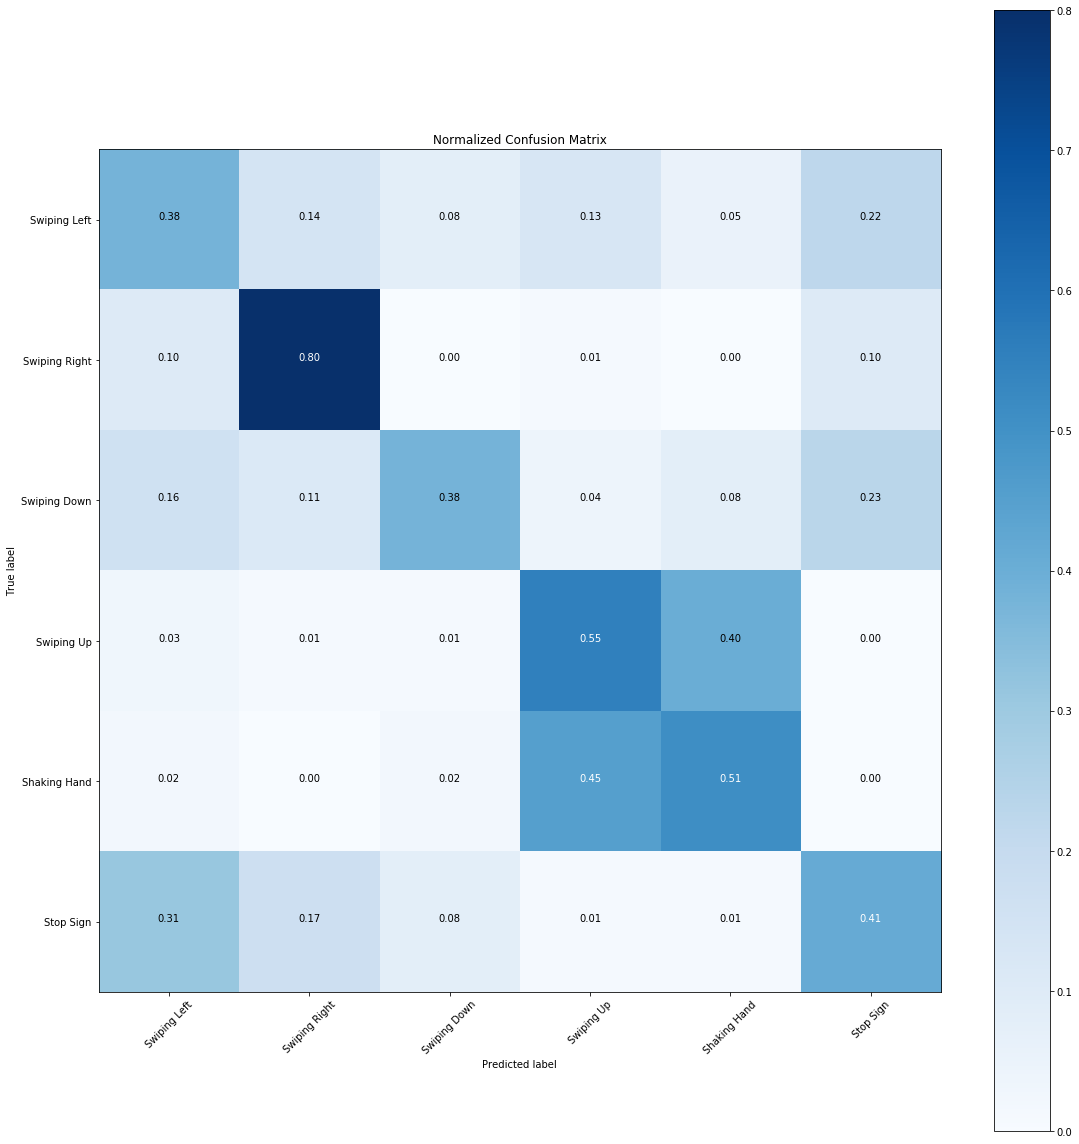

In [17]:
from sklearn.metrics import confusion_matrix
import itertools
# classes = ["Swiping Left","Swiping Right","Thumb Up","Shaking Hand","Stop Sign"]
classes = ["Swiping Left","Swiping Right","Swiping Down","Swiping Up","Shaking Hand","Stop Sign"]
met=confusion_matrix(y_val,y_pred)
cmap=plt.cm.Blues
met = met.astype('float') / met.sum(axis=1)[:, np.newaxis]
met = np.around(met, decimals=2)
met[np.isnan(met)] = 0.0
print(met)
plt.subplots(1, 1, figsize=(16, 16))
plt.imshow(met, interpolation='nearest', cmap=cmap)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = '.2f'
thresh = met.max() / 2.
for i, j in itertools.product(range(met.shape[0]), range(met.shape[1])):
    plt.text(j, i, format(met[i, j], fmt),
            horizontalalignment="center",
            color="white" if met[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('RS_images_2800')
plt.show()